In [101]:
import json
import requests
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [102]:
# Obetenção de dados (API)
# Carregando arquivo secrets.json
with open('secrets.json') as f:
    secrets = json.load(f)

api_key = secrets["WEATHER_API_KEY"]

# Coordenadas: Natal-RN
lat = '-5.79'
lon = '-35.21'

url = f"http://api.openweathermap.org/data/2.5/forecast?lat={lat}&lon={lon}&appid={api_key}"
response = requests.get(url)

In [ ]:
# Exibição retorno JSON 
data = response.json()
json_str = json.dumps(data, indent=4)
print(json_str)

In [104]:
# Funções
def kelvin_to_celcius(kelvin):
    celcius = kelvin - 273.15
    return celcius

def get_wind_direction(degrees):
    directions = ["N", "NE", "E", "SE", "S", "SW", "W", "NW"]
    index = round(degrees / (360 / 8))
    return directions[index % 8]

def meter_per_second_to_kilometer_per_hour(mps):
    kph = mps * 3.6
    return kph

In [105]:
# Tratamento e transformação de dados
if response.status_code == 200:
    data = response.json()
    weather_data = []

    for hour in data['list']:
        date_time = datetime.utcfromtimestamp(hour['dt']).strftime('%Y-%m-%d %H:%M:%S')
        temp = round(kelvin_to_celcius(hour['main']['temp']))
        feels_like = round(kelvin_to_celcius(hour['main']['feels_like']))
        humidity = hour['main']['humidity']
        weather_main = hour['weather'][0]['main']
        weather_description = hour['weather'][0]['description']
        wind_speed = meter_per_second_to_kilometer_per_hour(hour['wind']['speed'])
        wind_deg = hour['wind'].get('deg', 0)
        wind_direction = get_wind_direction(wind_deg)
        clouds_all = hour['clouds']['all']
        rain_volume = hour.get('rain', {}).get('3h', 0)

        weather_data.append({
            'DateTime': date_time,
            'Temperature (ºC)': temp,
            'Feels Like (ºC)': feels_like,
            'Humidity (%)': humidity,
            'Weather Main': weather_main,
            'Weather Description': weather_description,
            'Wind Speed (km/h)': wind_speed,
            'Wind Direction': wind_direction,
            'Cloudiness (%)': clouds_all,
            'Rain Volume (mm)': rain_volume,
        })

        df = pd.DataFrame(weather_data)
else:
  print(f"Failed to get data: {response.status_code}")

df.head()

,DateTime,Temperature (ºC),Feels Like (ºC),Humidity (%),Weather Main,Weather Description,Wind Speed (km/h),Wind Direction,Cloudiness (%),Rain Volume (mm)
0,2025-04-21 21:00:00,30,37,74,Clouds,scattered clouds,12.888,E,40,0.00
1,2025-04-22 00:00:00,29,35,76,Clouds,scattered clouds,13.176,E,33,0.00
2,2025-04-22 03:00:00,28,32,80,Clouds,scattered clouds,9.792,E,27,0.00
3,2025-04-22 06:00:00,25,26,88,Rain,light rain,8.424,SE,28,0.83
4,2025-04-22 09:00:00,25,26,91,Rain,light rain,9.000,SE,35,2.08


In [106]:
# Processamento de data/hora e geração de pivot table
df['DateTime'] =  pd.to_datetime(df['DateTime'])
df['Day'] = df['DateTime'].dt.day
df['Hour'] = df['DateTime'].dt.hour

df_pivot = df.pivot(index='Day', columns='Hour', values='Temperature (ºC)')
average_value = df['Temperature (ºC)'].mean()

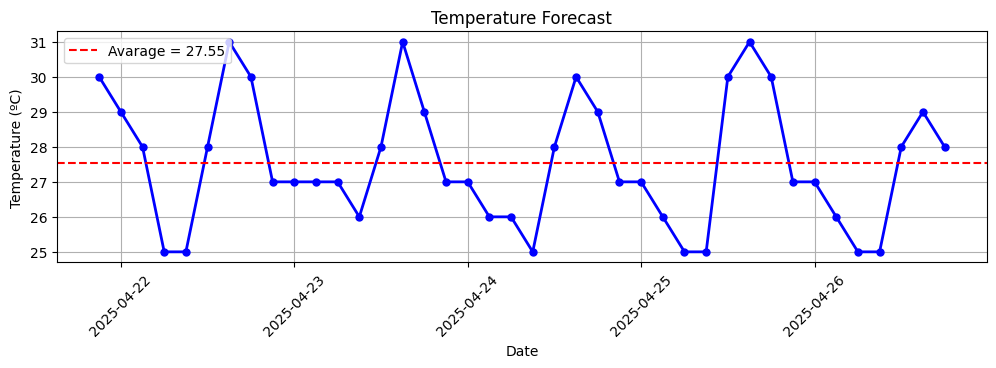

In [107]:
# Plot gráfico da temperatura em relação com a temperatura média
plt.figure(figsize=(12, 3))
plt.plot(df['DateTime'], df['Temperature (ºC)'], color='b', linestyle='-', linewidth=2, marker='o', markersize=5,)
plt.axhline(y=average_value, color='r', linestyle='--', label=f'Avarage = {average_value:.2f}')
plt.title('Temperature Forecast')
plt.xlabel('Date')
plt.ylabel('Temperature (ºC)')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

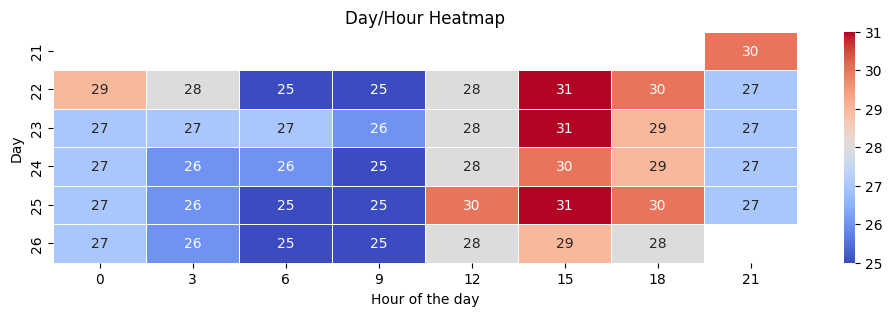

In [108]:
# Plot mapa de calor (Heatmap)
plt.figure(figsize=(12, 3))
sns.heatmap(df_pivot, cmap='coolwarm', annot=True, linewidths=.5)
plt.title('Day/Hour Heatmap')
plt.xlabel('Hour of the day')
plt.ylabel('Day')
plt.show()

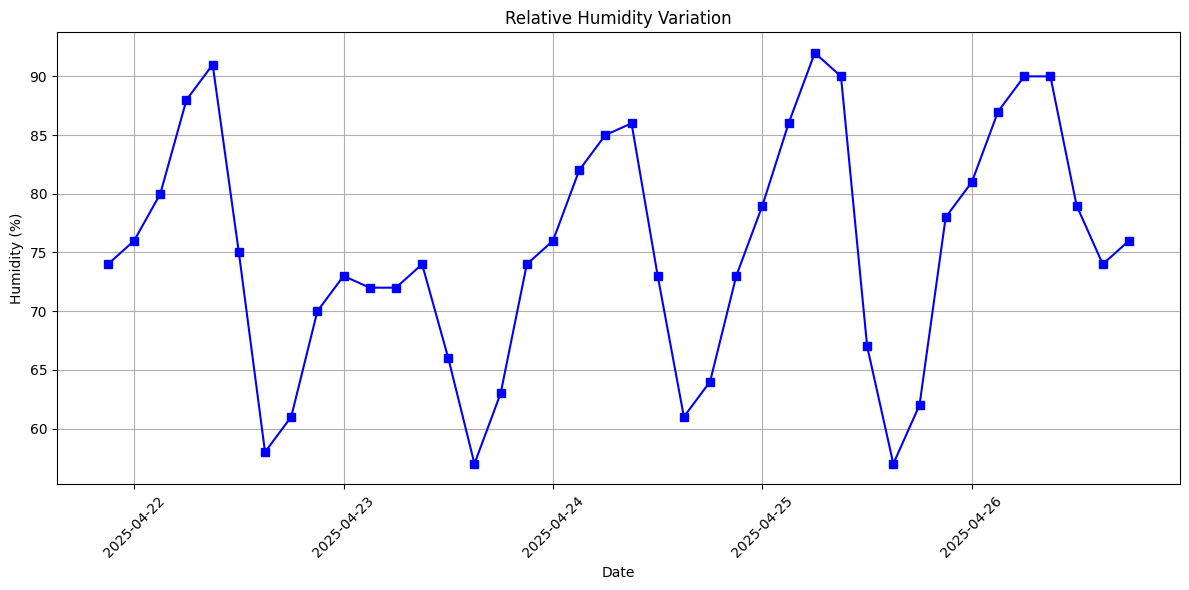

In [109]:
# Plotando gráfico referente a variação de humidade conforme o tempo
plt.figure(figsize=(12, 6))
plt.plot(df['DateTime'], df['Humidity (%)'], marker='s', color='b')
plt.title('Relative Humidity Variation')
plt.xlabel('Date')
plt.ylabel('Humidity (%)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [110]:
# Carregando os dados em um Data Warehouse
import pandas as pd
import psycopg2
from sqlalchemy import create_engine, text

In [111]:
# Criando engine e estabelecendo conexão com o banco de dados
with open('db_config.json') as f:
    db_config = json.load(f)

db_url = f'postgresql://{db_username}:{db_password}@{db_host}:{db_port}/{db_name}'

try:
    engine = create_engine(db_url)
    with engine.connect() as connection:
        connection.execute(text("SELECT 1"))
        print("Database connection established.")
except Exception as e:
    print(f"Error connecting to database: {e}")
    engine = None

Database connection established.


In [112]:
# Definindo o nome da tabela a ser criada
table_name = 'weather_data'

if engine:
    try:
        df.to_sql(table_name, engine, if_exists='replace', index=False)
        print(f"Table '{table_name}' created/replaced successfully.")
    except Exception as e:
        print(f"Error creating table '{table_name}': {e}")
    finally:
        engine.dispose()
        print("Database connection closed.")
else:
    print("The table could not be created because the engine was not initialized.")

Table 'weather_data' created/replaced successfully.
Database connection closed.
